<img align="left" src="https://drive.google.com/uc?export=view&id=1orv1XTixxkcGADz18uSwN_5kCtd1yM7q" alt="drawing" width="100%"/>

<img align="left" src="https://drive.google.com/uc?id=1dUhDyLOrHHP0ghjdb2ZhvyQZ0ZpcmoIm" alt="drawing" width="200"/> **<font color = 2b2b99 face="Times New Roman" size=7>Forêts aléatoires || Modèle bayésien || SVM (solutions) </font>**

L'objectif de ce tutoriel est d'appliquer sur un ensemble d'exemples les modèles suivants :


*   Forêts aléatoires
*   Modèle bayésien
*   Support vecteur machine



In [ ]:
#@markdown ### <font size=6 color='Red' face = "Times New Roman"> &nwarr;Exécutez cette cellule avant de débuter.</font>

# NE PAS TOUCHER À CETTE CELLULE
# Cette cellule installe les bibliothèques nécessaires pour que le calepin fonctionne.
# ici on spécifie les versions des bibliothèques
!pip install -q numpy==1.21.5 &> /dev/null #cache les erreurs de dépendance de numpy pour des packages qu'on n'utilise pas
!pip install -q pandas==1.3.5 &> /dev/null
!pip install -q matplotlib==3.2.2 &> /dev/null
!pip install -q scikit-learn==1.0.2 &> /dev/null
!pip install -q scikit-image==0.18.2 &> /dev/null
!pip install -q imgaug==0.2.5 &> /dev/null

!pip install -q requests==2.23.0 &> /dev/null
!pip install -q IPython==5.5.0 &> /dev/null

# # Il faut repartir le kernel
import warnings
import sys
with warnings.catch_warnings():
    print("Le calepin est prêt à être utilisé.")
    print("Si vous voyez un message de 'crash' en bas à gauche, c'est normal. ")
    exit()

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Les librairies</font>**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Les données</font>**

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Création de nos données</font>



> Dans ce jeu de données, des recommandations au sujet d'une école sont données en fonction de certains critères :
* TauxReussite : son taux de réussite.
* TauxInsertionProfessionnelle : le taux d'insertion professionnelle des élèves dans le marché de l'emploi.
* SalaireMoyen : le salaire moyen des élèves qui ont trouvé du travail.


In [ ]:
data = pd.DataFrame()  # on crée un tableau de données

np.random.seed(0) # random.seed c'est pour avoir des résultats qui sont reproductibles
data['TauxReussite'] = np.random.uniform(0.45, 0.95, 200) # on génère 200 valeurs de manière uniforme entre 0,45 et 0,95
data['TauxReussite'] = np.round(data['TauxReussite'], 2) # on arrondit ses valeurs à deux chiffres après la virgule

np.random.seed(1)
data['TauxInsertionProfessionnelle'] = np.random.uniform(0.45, 0.95, 200) 
data['TauxInsertionProfessionnelle'] = np.round(data['TauxInsertionProfessionnelle'], 2)

np.random.seed(2)
data['SalaireMoyen'] = np.random.uniform(60000, 100000, 200)
data['SalaireMoyen'] = np.round(data['SalaireMoyen'], 0)

np.random.seed(4)
data['Recommandation'] = np.random.choice(['Oui', 'Non'], 200) # on génère au hasard 200 valeurs qui sont soient « Oui » ou « Non »

data.head() # j'affiche quelques exemples

,TauxReussite,TauxInsertionProfessionnelle,SalaireMoyen,Recommandation
0,0.72,0.66,77440.0,Oui
1,0.81,0.81,61037.0,Oui
2,0.75,0.45,81986.0,Non
3,0.72,0.60,77413.0,Non
4,0.66,0.52,76815.0,Non


## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Transformation des données</font>



> On va transformer *Recommandation* en caractéristique binaire :
* 0 : Non
* 1 : Oui


---



In [ ]:
from sklearn.preprocessing import label_binarize ## c'est pour l'encodage binaire

data_transf = data.copy() # je fais une copie du data que je vais modifier
data_transf['Recommandation'] = label_binarize(data['Recommandation'], classes = ['Non', 'Oui']) # je remplace Recommandation par son encodage binaire

data_transf.head()

,TauxReussite,TauxInsertionProfessionnelle,SalaireMoyen,Recommandation
0,0.72,0.66,77440.0,1
1,0.81,0.81,61037.0,1
2,0.75,0.45,81986.0,0
3,0.72,0.60,77413.0,0
4,0.66,0.52,76815.0,0




---


> Par ailleurs, comme les données ont des ordres de grandeur différents (par exemple SalaireMoyen a des valeurs 100 000 fois plus importantes que celles des autres attributs), nous allons faire de la standardisation. Pour ce faire, il faut soustraire chaque attribut de sa moyenne et de le diviser par son écart type. Ainsi, un attribut aux valeurs élevées n'aura pas un poids plus important que les autres dans l'arbre. 


---




In [ ]:
from sklearn.preprocessing import StandardScaler ## pour la standardisation

X = data_transf.drop('Recommandation', axis = 1) # on retire la colonne des classes (Recommandation) pour ne garder que les attributs
X = X.to_numpy() # on transforme en matrice

X = StandardScaler().fit_transform(X) # standardisation des attributs

y = data_transf['Recommandation'] # y va représenter la colonne des classes (Recommandation) 
y = y.to_numpy()

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Séparation en données tests et d'entraînement</font>

In [ ]:
from sklearn.model_selection import train_test_split # pour séparer en données entraînement et test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Forêts aléatoires</font>**

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Entraînement et choix hyperparamètres</font>



> Pour le choix des hyperparamètres, on va tester avec GridSearchCV :
* 2 critères : « gini » et « entropy »;
* 3 valeurs différentes du nombre d'arbres : 50, 75 et 100.



In [ ]:
from sklearn.ensemble import RandomForestClassifier # librairie pour la forêt aléatoire
from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestClassifier(random_state=0) 

param_grid_rf = {"criterion": ["gini", "entropy"],
                 "n_estimators": [50, 75, 100]}

grid_search_rf = GridSearchCV(clf_rf, param_grid_rf, cv=5).fit(X_train, y_train) # on entraîne le modèle sur l'ensemble d'entraînement

In [ ]:
print('Les meilleurs paramètres sont:\n %s' % grid_search_rf.best_params_)

Les meilleurs paramètres sont:
 {'criterion': 'entropy', 'n_estimators': 50}


## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Évaluation</font>

In [ ]:
clf_rf = grid_search_rf.best_estimator_ # on prend donc le modèle avec les meilleurs hyperparamètres

In [ ]:
from sklearn.metrics import accuracy_score # pour calculer la performance

y_pred = clf_rf.predict(X_test) # prédictions à partir du modèle sur les données test
accuracy_score(y_test, y_pred)

0.48

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Modèle bayésien</font>**

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Entraînement et choix hyperparamètres</font>



> Comme les attributs sont numériques, on va utiliser le modèle de Bayes Gaussien. Pour ce modèle, nous allons considérer les hyperparamètres par défaut. Toutefois, vous pouvez vous inspirer de ce qui a été fait dans les forêts aléatoires si vous voulez tester d'autres valeurs d'hyperparamètres. 


In [ ]:
from sklearn.naive_bayes import GaussianNB # librairie pour le modèle de Bayes Gaussien.

clf_gnb = GaussianNB() 

clf_gnb.fit(X_train, y_train)

GaussianNB()

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Évaluation</font>

In [ ]:
y_pred = clf_gnb.predict(X_test) # prédictions à partir du modèle sur les données test
accuracy_score(y_test, y_pred)

0.48

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>SVM</font>**

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Entraînement et choix hyperparamètres</font>



> Pour le choix des hyperparamètres, on va aussi tester avec GridSearchCV :
* 4 noyaux différents : « linear » (linéaire), « poly » (polynomiale), « sigmoid », « rbf » (gaussien).  



In [ ]:
from sklearn import svm # librairie pour le svm

clf_svm = svm.SVC(random_state=0) # Avec SVM, on peut faire la classification (SVC) ou la régression (SVR)

param_grid_svm = {"kernel": ["linear", "poly", "sigmoid", "rbf"]}

grid_search_svm = GridSearchCV(clf_svm, param_grid_svm, cv=5).fit(X_train, y_train)

In [ ]:
print('Les meilleurs paramètres sont:\n %s' % grid_search_svm.best_params_)

Les meilleurs paramètres sont:
 {'kernel': 'poly'}


## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=6>Évaluation</font>

In [ ]:
clf_svm = grid_search_svm.best_estimator_ # on prend donc le modèle avec les meilleurs hyperparamètres

In [ ]:
y_pred = clf_svm.predict(X_test) # prédictions à partir du modèle sur les données test
accuracy_score(y_test, y_pred)

0.5

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Récapitulatif de tous les modèles</font>**

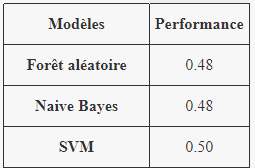

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Références</font>**


1.   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
2.   https://scikit-learn.org/stable/modules/naive_bayes.html
3.   https://scikit-learn.org/stable/modules/svm.html
4.   https://scikit-learn.org/stable/modules/neural_networks_supervised.html
5.   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



